## Load Diabetes Data

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes
data, avg_blood_suger = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


<AxesSubplot:>

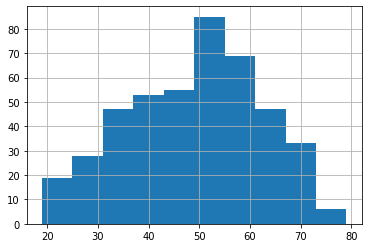

In [3]:
data['age'].hist()

## Inserting Univariate Drift

We will create univariate drift in the 'age' feature
making the test set contain a larger portion of elderly people.

In [13]:
younger = list(data[data['age'] < 50].index)
older = list(data[data['age'] >= 50].index)

train_mixture = random.sample(younger, int(0.9 * len(younger))) + random.sample(older, int(0.3 * len(older)))

In [14]:
train_X, train_y = data[data.index.isin(train_mixture)], avg_blood_suger[avg_blood_suger.index.isin(train_mixture)]
test_X, test_y = data[~data.index.isin(train_mixture)], avg_blood_suger[~avg_blood_suger.index.isin(train_mixture)]

train_X.shape, test_X.shape

((260, 10), (182, 10))

## Drift effect on performance

We will train a simple model to demonstrate the effect drift can have on performance:

In [15]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size = 0.25)
  
regr = DecisionTreeRegressor(max_depth=5, random_state = 42) 
regr.fit(X_train, y_train)

print(f'Mean squared error on validation set is: {mean_squared_error(y_val, regr.predict(X_val))}')
print(f'Mean squared error on test set is: {mean_squared_error(test_y, regr.predict(test_X))}')

Mean squared error on validation set is: 3179.9926487853973
Mean squared error on test set is: 6806.0786251390255


## Detecting univariate drift using Earth Mover's Distance

For addtional infromation about Earth Mover's distanct and other drift method see [link](https://docs.deepchecks.com/stable/user-guide/general/drift_guide.html).

In [16]:
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import TrainTestFeatureDrift

train_dataset = Dataset(train_X, train_y, cat_features=['sex'])
test_dataset = Dataset(test_X, test_y, cat_features=['sex'])

TrainTestFeatureDrift(columns=['age', 'sex']).run(train_dataset,test_dataset)

## Inserting Multivariate Drift

In the following split, the training data will contain either young males or elderly females. </br>
Even though the train and test sets have different distributions, there is no univariate drift in any of the features.

In [17]:
data['sex'] = data.sex.apply({1:'Male', 2:'Female'}.get)
young_males = data[(data['age'] < 50) & (data['sex'] == 'Male')].index
elderly_females = data[(data['age'] >= 50) & (data['sex'] == 'Female')].index

train_mixture = list(young_males) + list(elderly_females)

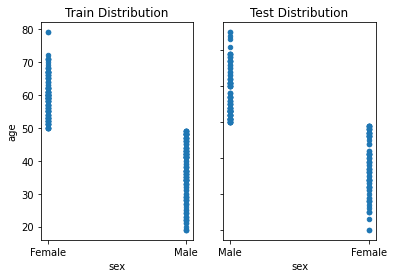

In [18]:
train_X, train_y = data[data.index.isin(train_mixture)], avg_blood_suger[avg_blood_suger.index.isin(train_mixture)]
test_X, test_y = data[~data.index.isin(train_mixture)], avg_blood_suger[~avg_blood_suger.index.isin(train_mixture)]

fig, axes = plt.subplots(nrows=1,ncols=2)
train_X.plot(ax = axes[0],x='sex', y='age', subplots=True, kind='scatter', sharey=True)
axes[0].title.set_text('Train Distribution')
test_X.plot(ax = axes[1],x='sex', y='age', subplots=True, kind='scatter', sharey=True)
axes[1].title.set_text('Test Distribution')

We have inserted substancial drift, yet it cannot be discovered by the previeus univariate methods:

In [19]:
train_dataset = Dataset(train_X, train_y, cat_features=['sex'])
test_dataset = Dataset(test_X, test_y, cat_features=['sex'])

TrainTestFeatureDrift(columns=['age','sex']).run(train_dataset,test_dataset)

## Detecting multivariate drift using Domain Classifier

Domain classifier is a model train to discriminate between train and test samples. </br>
Better model performance indicate higher presence of drift. For additional details see [link](https://docs.deepchecks.com/stable/checks_gallery/tabular/train_test_validation/plot_multivariate_drift.html).

In [20]:
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import MultivariateDrift

train_dataset = Dataset(train_X, train_y, cat_features=['sex'])
test_dataset = Dataset(test_X, test_y, cat_features=['sex'])

MultivariateDrift(columns=['age','sex']).run(train_dataset,test_dataset)